In [69]:
from decouple import Config, RepositoryEnv
from json import dumps
import json
import openai
from langchain.prompts import ChatPromptTemplate
from langchain.chat_models import ChatOpenAI
import pandas as pd
from pydantic import BaseModel, ValidationError, Field
from typing import List, Tuple , Union, Optional
from langchain.schema import HumanMessage, SystemMessage, AIMessage

In [70]:
from sentence_transformers import SentenceTransformer, util

In [71]:
import time
import matplotlib.pyplot as plt
import seaborn as sns

In [72]:
DOTENV_FILE = 'C:\\Users\\Tiziano Pacifico\\Desktop\\OpenAICourses\\.env'
env_config = Config(RepositoryEnv(DOTENV_FILE))
openai.api_key = env_config.get('CHATGPT_API_KEY')

In [73]:
path = "C:\\Users\\Tiziano Pacifico\\Desktop\\Applicativi personali\\Test Bertopic\Output\\"
filename = "bert_result.json"

In [74]:
df = pd.read_json(path+filename,lines=True)

In [75]:
def create_topwords_string(top_words_list):
    topwords_string = ''
    for line in top_words_list:
        topwords_string += f"({line[0]}, {line[1]}) "
    return topwords_string

In [76]:
df['top_words'].iloc[0]

[['culture', 0.1025166737],
 ['pop', 0.0867954693],
 ['popular', 0.060102045400000005],
 ['entertainment', 0.0443290389],
 ['fashion', 0.0409196078],
 ['norms', 0.0384180662],
 ['trends', 0.0366076776],
 ['societal', 0.0344830633],
 ['movies', 0.0320962724],
 ['influence', 0.026422253200000002],
 ['society', 0.023914337900000002],
 ['choices', 0.0238645743],
 ['shows', 0.0234683147],
 ['influenced', 0.0230960484],
 ['representation', 0.022744625100000002],
 ['diverse', 0.0196185865],
 ['it', 0.0193858108],
 ['its', 0.018870697000000002],
 ['the', 0.018656005700000002],
 ['has', 0.0183413044],
 ['shapes', 0.0181665867],
 ['our', 0.0171312625],
 ['and', 0.016799046],
 ['for', 0.0167709762],
 ['instance', 0.0167546547],
 ['beliefs', 0.016390110700000002],
 ['by', 0.016293981000000003],
 ['in', 0.015478194],
 ['television', 0.0149687415],
 ['music', 0.0145265451]]

In [77]:
df['top_words_str'] = df['top_words'].apply(create_topwords_string)

In [78]:
df['top_words_str'].iloc[0]

'(culture, 0.1025166737) (pop, 0.0867954693) (popular, 0.060102045400000005) (entertainment, 0.0443290389) (fashion, 0.0409196078) (norms, 0.0384180662) (trends, 0.0366076776) (societal, 0.0344830633) (movies, 0.0320962724) (influence, 0.026422253200000002) (society, 0.023914337900000002) (choices, 0.0238645743) (shows, 0.0234683147) (influenced, 0.0230960484) (representation, 0.022744625100000002) (diverse, 0.0196185865) (it, 0.0193858108) (its, 0.018870697000000002) (the, 0.018656005700000002) (has, 0.0183413044) (shapes, 0.0181665867) (our, 0.0171312625) (and, 0.016799046) (for, 0.0167709762) (instance, 0.0167546547) (beliefs, 0.016390110700000002) (by, 0.016293981000000003) (in, 0.015478194) (television, 0.0149687415) (music, 0.0145265451) '

In [79]:
systemMessage = SystemMessage(content="""You will act as a topic label creator. \
You will create a label that identify a topic given a set of 30 keywords that are meaningfull for the topic.\
                               The topic can be one word or one short sentence, depending how many words you need\
                              to capture the essence of the text. The text will be given in input as human message. Give as output just the sentence or the words that identify the topic.\
                              The keywords list will be given as a result of a BERTopic alghoritm over a short article in the following format: ###\
                              \(celebrities, 0.0569693501) (influence, 0.0549841217) (their, 0.0467051602) (the, 0.044765043500000004) (and, 0.0443447511) (culture, 0.042227265) (to, 0.0411800998)....\
                                where each number after the word state how important is the word in the topic description in terms of c-TF_IDF score""")

In [80]:
df.head()

,Articolo,Argomento,Descrizione,Topic,top_words,top_words_str
0,"Pop culture, short for popular culture, refers...",The Influence of Pop Culture on Society,Explore how popular culture trends influence f...,38,"[[culture, 0.1025166737], [pop, 0.0867954693],...","(culture, 0.1025166737) (pop, 0.0867954693) (p..."
1,"In our fast-paced and hectic lives, we often f...",The Benefits of Mindful Eating,Learn how practicing mindful eating can improv...,29,"[[eating, 0.1186194418], [food, 0.0718457016],...","(eating, 0.1186194418) (food, 0.0718457016) (m..."
2,Financial literacy is a crucial skill that eve...,The Importance of Financial Literacy,Learn about the significance of understanding ...,49,"[[financial, 0.1605916457], [literacy, 0.09661...","(financial, 0.1605916457) (literacy, 0.0966170..."
3,Fast fashion has become a dominant force in th...,The Impact of Fast Fashion on the Environment,Explore the environmental consequences of fast...,33,"[[fashion, 0.09808000430000001], [fast, 0.0800...","(fashion, 0.09808000430000001) (fast, 0.080015..."
4,Physical exercise has long been known to have ...,The Benefits of Regular Exercise for Mental He...,Learn how physical activity can improve mental...,21,"[[exercise, 0.0724763518], [mental, 0.05382092...","(exercise, 0.0724763518) (mental, 0.05382092) ..."


In [81]:
BERT_out = list(df['top_words_str'].unique())

In [82]:
chat = ChatOpenAI(temperature=0.7, model="gpt-3.5-turbo-0613")

In [83]:
GPT_topics = []
for i,out in enumerate(BERT_out):
    humanMessage=HumanMessage(content=f"Create a topic label for the following LDA output{out}")
    messages = [systemMessage, humanMessage]
    topic = chat(messages)
    print(f"elaborato messaggio n: {i}")
    GPT_topics.append((out,topic))

elaborato messaggio n: 0
elaborato messaggio n: 1
elaborato messaggio n: 2
elaborato messaggio n: 3
elaborato messaggio n: 4
elaborato messaggio n: 5
elaborato messaggio n: 6
elaborato messaggio n: 7
elaborato messaggio n: 8
elaborato messaggio n: 9
elaborato messaggio n: 10
elaborato messaggio n: 11
elaborato messaggio n: 12
elaborato messaggio n: 13
elaborato messaggio n: 14
elaborato messaggio n: 15
elaborato messaggio n: 16
elaborato messaggio n: 17
elaborato messaggio n: 18
elaborato messaggio n: 19
elaborato messaggio n: 20
elaborato messaggio n: 21
elaborato messaggio n: 22
elaborato messaggio n: 23
elaborato messaggio n: 24
elaborato messaggio n: 25
elaborato messaggio n: 26
elaborato messaggio n: 27
elaborato messaggio n: 28
elaborato messaggio n: 29
elaborato messaggio n: 30
elaborato messaggio n: 31
elaborato messaggio n: 32
elaborato messaggio n: 33
elaborato messaggio n: 34
elaborato messaggio n: 35
elaborato messaggio n: 36
elaborato messaggio n: 37
elaborato messaggio n:

In [84]:
GPT_topics_str = []
for s in GPT_topics:
    GPT_topics_str.append((s[0],s[1].content))

In [85]:
GPT_topics_clean = []
for topic in GPT_topics_str:
    if len(topic[1].split("\"")) > 1:
        GPT_topics_clean.append((topic[0],topic[1].split("\"")[1]))
    else:GPT_topics_clean.append(topic)

In [86]:
GPT_topics_clean[0][0]

'(culture, 0.1025166737) (pop, 0.0867954693) (popular, 0.060102045400000005) (entertainment, 0.0443290389) (fashion, 0.0409196078) (norms, 0.0384180662) (trends, 0.0366076776) (societal, 0.0344830633) (movies, 0.0320962724) (influence, 0.026422253200000002) (society, 0.023914337900000002) (choices, 0.0238645743) (shows, 0.0234683147) (influenced, 0.0230960484) (representation, 0.022744625100000002) (diverse, 0.0196185865) (it, 0.0193858108) (its, 0.018870697000000002) (the, 0.018656005700000002) (has, 0.0183413044) (shapes, 0.0181665867) (our, 0.0171312625) (and, 0.016799046) (for, 0.0167709762) (instance, 0.0167546547) (beliefs, 0.016390110700000002) (by, 0.016293981000000003) (in, 0.015478194) (television, 0.0149687415) (music, 0.0145265451) '

In [87]:
df.head()

,Articolo,Argomento,Descrizione,Topic,top_words,top_words_str
0,"Pop culture, short for popular culture, refers...",The Influence of Pop Culture on Society,Explore how popular culture trends influence f...,38,"[[culture, 0.1025166737], [pop, 0.0867954693],...","(culture, 0.1025166737) (pop, 0.0867954693) (p..."
1,"In our fast-paced and hectic lives, we often f...",The Benefits of Mindful Eating,Learn how practicing mindful eating can improv...,29,"[[eating, 0.1186194418], [food, 0.0718457016],...","(eating, 0.1186194418) (food, 0.0718457016) (m..."
2,Financial literacy is a crucial skill that eve...,The Importance of Financial Literacy,Learn about the significance of understanding ...,49,"[[financial, 0.1605916457], [literacy, 0.09661...","(financial, 0.1605916457) (literacy, 0.0966170..."
3,Fast fashion has become a dominant force in th...,The Impact of Fast Fashion on the Environment,Explore the environmental consequences of fast...,33,"[[fashion, 0.09808000430000001], [fast, 0.0800...","(fashion, 0.09808000430000001) (fast, 0.080015..."
4,Physical exercise has long been known to have ...,The Benefits of Regular Exercise for Mental He...,Learn how physical activity can improve mental...,21,"[[exercise, 0.0724763518], [mental, 0.05382092...","(exercise, 0.0724763518) (mental, 0.05382092) ..."


In [88]:
def add_topic_label(df_col):
    for topic in GPT_topics_clean:
        if topic[0] == df_col:
            return topic[1]

In [89]:
df['GPT_label'] = df['top_words_str'].apply(add_topic_label)

In [105]:
df[df['Similarity'] > 0.95]

,Articolo,Argomento,Descrizione,Topic,top_words,top_words_str,GPT_label,Similarity,Similarity class
4,Physical exercise has long been known to have ...,The Benefits of Regular Exercise for Mental He...,Learn how physical activity can improve mental...,21,"[[exercise, 0.0724763518], [mental, 0.05382092...","(exercise, 0.0724763518) (mental, 0.05382092) ...",The Benefits of Regular Exercise for Mental He...,1.000000,< 1.0
8,It’s no secret that regular exercise is essent...,The Benefits of Regular Exercise for Mental He...,Learn how physical activity can improve mental...,21,"[[exercise, 0.0724763518], [mental, 0.05382092...","(exercise, 0.0724763518) (mental, 0.05382092) ...",The Benefits of Regular Exercise for Mental He...,1.000000,< 1.0
13,Parenting is one of the most important and cha...,The Benefits of Positive Parenting,Explore the advantages of adopting positive pa...,1,"[[positive, 0.0863371671], [mindset, 0.0457818...","(positive, 0.0863371671) (mindset, 0.045781882...",Positive Parenting and Mindset,0.955261,< 1.0
52,Positive parenting is a parenting style that f...,The Benefits of Positive Parenting,Explore the advantages of adopting positive pa...,1,"[[positive, 0.0863371671], [mindset, 0.0457818...","(positive, 0.0863371671) (mindset, 0.045781882...",Positive Parenting and Mindset,0.955261,< 1.0
53,One of the most significant consequences of cy...,The Impact of Cybersecurity Threats,Explore the consequences of cyber threats and ...,47,"[[threats, 0.0981638703], [cybersecurity, 0.09...","(threats, 0.0981638703) (cybersecurity, 0.0907...",Cybersecurity Threats and Consequences,0.981635,< 1.0
54,Music has a powerful impact on our emotions an...,The Influence of Music on Mood and Emotions,"Learn how music can affect emotions, reduce st...",41,"[[music, 0.14408743770000002], [emotions, 0.05...","(music, 0.14408743770000002) (emotions, 0.0500...",The Influence of Music on Emotions and Mood,0.998788,< 1.0
80,Exercise is often associated with physical hea...,The Benefits of Regular Exercise for Mental He...,Learn how physical activity can improve mental...,21,"[[exercise, 0.0724763518], [mental, 0.05382092...","(exercise, 0.0724763518) (mental, 0.05382092) ...",The Benefits of Regular Exercise for Mental He...,1.000000,< 1.0
118,"In today's digital age, cybersecurity threats ...",The Impact of Cybersecurity Threats,Explore the consequences of cyber threats and ...,47,"[[threats, 0.0981638703], [cybersecurity, 0.09...","(threats, 0.0981638703) (cybersecurity, 0.0907...",Cybersecurity Threats and Consequences,0.981635,< 1.0
137,Music has a profound impact on our emotions an...,The Influence of Music on Mood and Emotions,"Learn how music can affect emotions, reduce st...",41,"[[music, 0.14408743770000002], [emotions, 0.05...","(music, 0.14408743770000002) (emotions, 0.0500...",The Influence of Music on Emotions and Mood,0.998788,< 1.0
140,Positive parenting is an approach to raising c...,The Benefits of Positive Parenting,Explore the advantages of adopting positive pa...,1,"[[positive, 0.0863371671], [mindset, 0.0457818...","(positive, 0.0863371671) (mindset, 0.045781882...",Positive Parenting and Mindset,0.955261,< 1.0


In [91]:
model = SentenceTransformer('bert-base-nli-mean-tokens')

In [92]:
original_topic_embeddings = model.encode(list(df['Argomento']), convert_to_tensor=True)
GPT_topic_embeddings = model.encode(list(df['GPT_label']), convert_to_tensor=True)

In [93]:
sim = []
for a,b in zip(original_topic_embeddings,GPT_topic_embeddings):
    value = util.pytorch_cos_sim(a.unsqueeze(0), b.unsqueeze(0))
    sim.append(value.item())

In [94]:
max(sim)

0.9999998807907104

In [95]:
min(sim)

0.5127623677253723

In [96]:
sum(sim)/len(sim)

0.8316077800591787

In [97]:
df['Similarity'] = sim

In [98]:
def reclass_similarity(similarity):
    start = 0.6
    end = 1.0
    classi = [x / 10.0 for x in range(int(start * 10), int(end * 10) + 1)]
    for classe in classi:
        if similarity < classe:
            return "< " + str(classe)

In [99]:
df['Similarity class'] = df['Similarity'].apply(reclass_similarity)

In [100]:
df_freq_sim = df.groupby('Similarity class').size().reset_index(name='Frequenza')

In [101]:
df_freq_sim.head()

,Similarity class,Frequenza
0,< 0.6,8
1,< 0.7,4
2,< 0.8,94
3,< 0.9,117
4,< 1.0,77


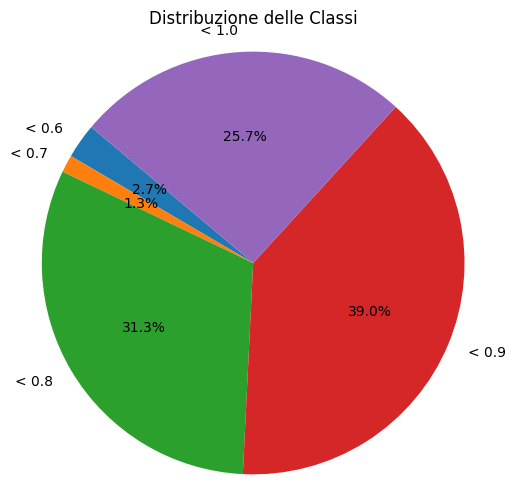

In [102]:
plt.figure(figsize=(6, 6))  # Imposta la dimensione del grafico
plt.pie(df_freq_sim['Frequenza'], labels=df_freq_sim['Similarity class'], autopct='%1.1f%%', startangle=140)

# Aggiunge un titolo
plt.title('Distribuzione delle Classi')

# Mostra il grafico
plt.axis('equal')  # Imposta gli assi per avere un aspetto circolare
plt.show()